Using "Physics-informed neural network" to solve a classic beam dynamic equation which is a 4th order PDE(Partial differential equation).
Free vibration of a simple supported beam:
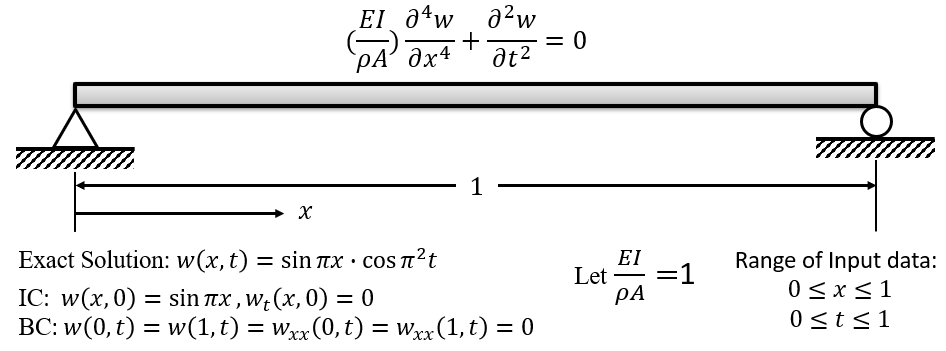

About Physics-informed neural network:
Raissi, Maziar, Paris Perdikaris, and George E. Karniadakis. "Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations." Journal of Computational physics 378 (2019): 686-707.

In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data.dataset import Dataset
from time import time

import random
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': print(torch.cuda.get_device_name()) 

cuda


In [2]:
# create custom dataset
class CustomDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None):
        self.inputs=X
        self.labels=y
        
    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        inp=self.inputs[idx]
        lab=self.labels[idx]
        return inp, lab

In [27]:
# Define Physics-informed neural networks by a 2x100x100x100x1 ANN
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 100),
            nn.Tanh(),
            #nn.ReLU(),
            
            nn.Linear(100, 100),
            nn.Tanh(),
            #nn.ReLU(),
            
            nn.Linear(100, 100),
            nn.Tanh(),
            #nn.ReLU(),
            
            nn.Linear(100, 1)
            #nn.Tanh()
        )

    def forward(self, x):
        outputs=self.linear_relu_stack(x)
        return outputs



In [28]:
PINN = NeuralNetwork().to(device).double()
print(PINN)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Tanh()
    (6): Linear(in_features=100, out_features=1, bias=True)
  )
)


In [5]:
ub=1
lb=0

In [6]:
# get the loss of pde:  
# The sum of (4th order derivative respect to x) and (2nd order derivative respect to t ) should be to zero.
def pde_loss(data,model):
    
    x=data[:,0].reshape(len(data),1)
    t=data[:,1].reshape(len(data),1)

    x.requires_grad_()
    t.requires_grad_()

    x1=2*(x-lb)/(ub-lb)-1
    t1=2*(t-lb)/(ub-lb)-1

    all_zero=np.zeros((len(x),1))
    all_zero=torch.from_numpy(all_zero).to(device)    

    w=model(torch.cat((x1,t1),1))
    w_x = torch.autograd.grad(w, x,torch.ones_like(w), create_graph=True)[0]
    w_xx= torch.autograd.grad(w_x,x,torch.ones_like(w_x), create_graph=True)[0]
    w_xxx= torch.autograd.grad(w_xx,x,torch.ones_like(w_xx), create_graph=True)[0]
    w_xxxx= torch.autograd.grad(w_xxx,x,torch.ones_like(w_xxx), create_graph=True)[0]
    
    w_t = torch.autograd.grad(w, t,torch.ones_like(w), create_graph=True)[0]
    w_tt= torch.autograd.grad(w_t,t,torch.ones_like(w_t), create_graph=True)[0]
    pde = w_xxxx+w_tt
    loss_pde_mse=loss_fn(pde, all_zero)
    torch.autograd.no_grad()
    return loss_pde_mse


In [7]:
#Boundary condition:
# zero at both end / and 2nd derivative respect to x equal to zero
def loss_bc (x,t,model):

    y=np.zeros([len(x),1])
    t=torch.from_numpy(t).to(device)
    x=torch.from_numpy(x).to(device) 
    y=torch.from_numpy(y).to(device)  
    
    x.requires_grad_()
    t.requires_grad_()
    x1=2*(x-lb)/(ub-lb)-1
    t1=2*(t-lb)/(ub-lb)-1
    w=model(torch.cat((x1,t1),1))
    w_x = torch.autograd.grad(w, x,torch.ones_like(w), create_graph=True)[0]
    w_xx= torch.autograd.grad(w_x,x,torch.ones_like(w_x), create_graph=True)[0]
    
    loss=loss_fn(w,y)+ loss_fn(w_xx,y)
    torch.autograd.no_grad()
    return loss

In [8]:
#Initial condition:
# w=sin(pi*x) when t=0/ 1st derivative respect to t equal to zero
def loss_ic (x,t,model):

    y1=np.sin(np.pi*x)
    y2=np.zeros([len(x),1])

    t=torch.from_numpy(t).to(device)
    x=torch.from_numpy(x).to(device) 
    y1=torch.from_numpy(y1).to(device) 
    y2=torch.from_numpy(y2).to(device) 
    
    x.requires_grad_()
    t.requires_grad_()
    x1=2*(x-lb)/(ub-lb)-1
    t1=2*(t-lb)/(ub-lb)-1
    w=model(torch.cat((x1,t1),1))
    w_t = torch.autograd.grad(w, t,torch.ones_like(w), create_graph=True)[0]
    
    loss=loss_fn(w,y1)+ loss_fn(w_t,y2)
    torch.autograd.no_grad()
    return loss

In [9]:
# a1,a2,a3 are the tunable coefficients for total loss function
a1=1
a2=1
a3=1

def train_pde(dataloader,batch_size, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    batch_number=len(dataloader)
    model.train()
    lossT,lossPde,lossIC,lossBC=0,0,0,0
    for batch, (X, y) in enumerate(dataloader):
        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)

        # Compute pde loss
        loss_pde_mse=pde_loss(X,model) # shape(N,1)

        # Compute iC loss
        x_ic=np.random.uniform(low=0.0, high=1, size=(50,1))
        t_ic=np.zeros([50,1])
        loss_i=loss_ic(x_ic,t_ic,model)

        # Compute BC loss
        t_bc=np.random.uniform(low=0.0, high=1, size=(50,1))
        x1=np.zeros([25,1])
        x2=np.ones([25,1])
        x_bc=np.concatenate((x1, x2), axis=0)      
        loss_b=loss_bc(x_bc,t_bc,model)
        
        # sum all loss
        loss = a1*loss_pde_mse+a2*loss_i+a3*loss_b

        # Backpropagation

        loss.backward()
        optimizer.step()
        
        lossT+= loss.item()
        lossPde+= loss_pde_mse.item()  
        lossIC+= loss_i.item()         
        lossBC+= loss_b.item()                
        torch.autograd.no_grad()

    print(f"loss: {lossT/batch_number:>7f},loss_pde_mse: {lossPde/batch_number:>7f},loss_i: {lossIC/batch_number:>7f},loss_b: {lossBC/batch_number:>7f} ")
    return lossT/batch_number

In [10]:
#choose loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(PINN.parameters(), lr=1e-3)


In [11]:
def data_prepare(Nf,B_size):
    #random training data
    train_y=np.ones([Nf,1])
    train_X=np.random.rand(Nf,2)

    for i in range(len(train_X)):
        x=train_X[i,0]
        t=train_X[i,1]    
        train_y[i]=np.sin(np.pi*x)*np.cos(np.pi**2*t)

    train_X=torch.from_numpy(train_X)
    train_y=torch.from_numpy(train_y)
    training_data=CustomDataset(train_X,train_y)

    # Create data loaders.
    train_dataloader = DataLoader(training_data, batch_size=B_size,shuffle=True)
    
    return train_dataloader
    

In [ ]:
Nf=2500
B_size=2500
epochs = 1000
train_loss, test_loss=[],[]
for t in range(epochs):
    train_dataloader= data_prepare(Nf,B_size)
    time0=time()
    
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss.append(train_pde(train_dataloader,B_size, PINN, loss_fn, optimizer))
    #test_loss.append(test(test_dataloader, model, loss_fn))
    print("\nTraining Time (in minutes) =",(time()-time0)/60)
print("Done!")

In [ ]:
# save model
torch.save(PINN.state_dict(), "PINN_norm_1_1000.pth")

In [29]:
#load model
#PINN.load_state_dict(torch.load("PINN_pre_4_1000.pth",map_location='cpu'))
PINN.load_state_dict(torch.load("model_norm_1_1000_L1899.pth"))

<All keys matched successfully>

In [13]:
# create fix points as training data for LBFGS
train_X=np.ones([22500,2])
train_y=np.ones([22500,1])
for i in range(150):
    for j in range(150):
        x=(i+1)*(1/151)
        t=(j+1)*(1/151)
        train_X[i*150+j]=[x,t]
        train_y[i*150+j]=np.sin(np.pi*x)*np.cos(np.pi**2*t) 
    
train_X=torch.from_numpy(train_X)
train_X=train_X.to(device)
train_y=torch.from_numpy(train_y)
train_y=train_y.to(device)

In [ ]:
epochs = 3

optimizer =torch.optim.LBFGS(PINN.parameters(), 
                             lr=1,
                             #max_iter = 1000, 
                             #max_eval = None, 
                             #tolerance_grad = 1e-06, 
                             #tolerance_change = 1e-09, 
                             #history_size = 100, 
                             line_search_fn = 'strong_wolfe')

for epoch in range(epochs):
    time0=time()
    running_loss = 0.0

    def closure():
        # Zero gradients
        optimizer.zero_grad()

        # Compute pde loss
        loss_pde_mse=pde_loss(train_X,PINN) 

        # Compute iC loss
        x_ic=np.linspace(0,1,150).reshape(150,1)
        t_ic=np.zeros([150,1])
        loss_i=loss_ic(x_ic,t_ic,PINN)

        # Compute BC loss
        t_1=np.linspace(0,1,150).reshape(150,1)
        x1=np.zeros([150,1])
        x2=np.ones([150,1])
        x_bc=np.concatenate((x1, x2), axis=0)
        t_bc=np.concatenate((t_1, t_1), axis=0)
        loss_b=loss_bc(x_bc,t_bc,PINN)

        #total loss
        loss = loss_pde_mse+loss_i+loss_b

        # Backward pass
        loss.backward()

        return loss
    # Update weights
    optimizer.step(closure)

    # Update the running loss
    loss = closure()
    running_loss += loss.item()
    train_loss.append(loss.item())

    print(f"Epoch: {epoch + 1:02}/{epochs} Loss: {running_loss:.5e}")
    print("\nTraining Time (in minutes) =",(time()-time0)/60)
    if epoch % 100 == 99:
      torch.save(PINN.state_dict(), f"PINN_norm_1_1000_L{epoch}.pth")
      np.savetxt(f"train_loss_PINN_norm_1_1000_L{epoch}.csv", train_loss, delimiter=",")

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='Training loss')
#plt.plot(test_loss, label='test loss')
plt.yscale("log")
plt.legend(frameon=False)
plt.show()

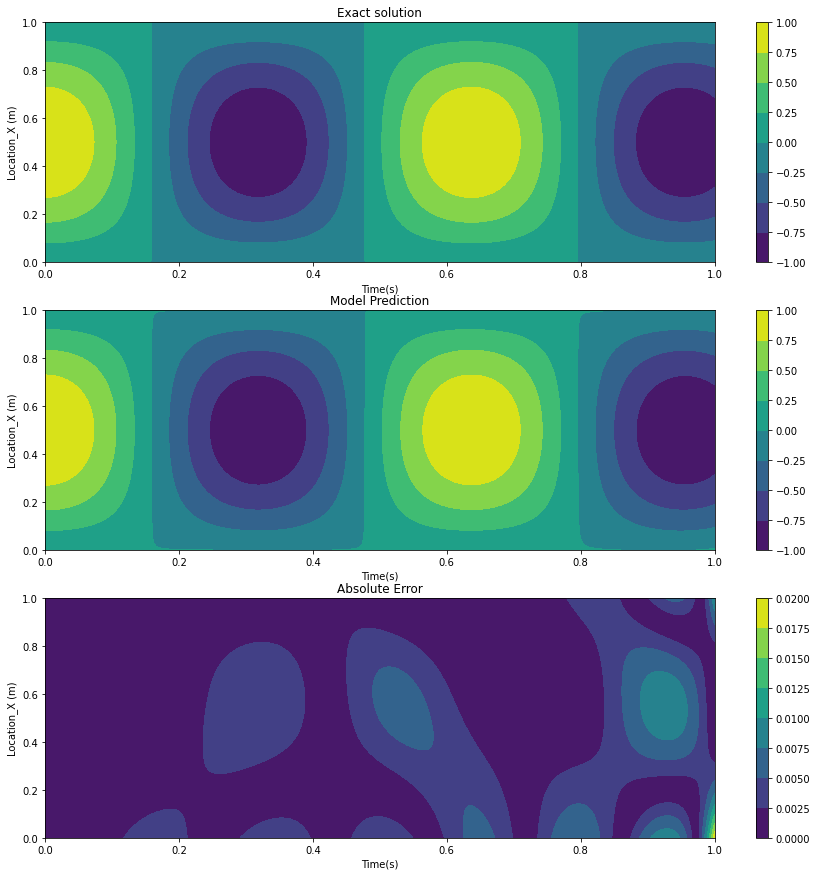

In [37]:
# plot the results
Xaxis=np.linspace(0,1,152)
taxis=np.linspace(0,1,151)
inputX=np.ones([len(taxis)*len(Xaxis),2])
true_y=np.ones([len(taxis)*len(Xaxis),1])
for i in range(len(Xaxis)):
    for j in range(len(taxis)):
        x=Xaxis[i]
        t=taxis[j]
        inputX[i*len(taxis)+j]=[x,t]
        true_y[i*len(taxis)+j]=np.sin(np.pi*x)*np.cos(np.pi**2*t)
inputX1=2*(inputX-lb)/(ub-lb)-1
inputX1=torch.from_numpy(inputX1)
PINN.eval()
X= inputX1.to(device)
pred_X = PINN(X).cpu().detach().numpy()

pred_X=pred_X.reshape(len(Xaxis),len(taxis))
true_y=true_y.reshape(len(Xaxis),len(taxis))

levels = np.linspace(-1,1,9)

fig_1 = plt.figure(1, figsize=(15, 15))
plt.subplot(3,1,1)
plt.title('Exact solution')
plt.contourf(taxis,Xaxis,true_y)
plt.xlabel('Time(s)')
plt.ylabel('Location_X (m)')
plt.xticks(np.arange(0, 1.2, 0.2))
plt.yticks(np.arange(0, 1.2, 0.2))       
plt.colorbar()

plt.subplot(3,1,2)
plt.title('Model Prediction')
plt.contourf(taxis,Xaxis,pred_X,levels)
plt.xlabel('Time(s)')
plt.ylabel('Location_X (m)')
plt.xticks(np.arange(0, 1.2, 0.2))
plt.yticks(np.arange(0, 1.2, 0.2))       
plt.colorbar()


plt.subplot(3,1,3)
plt.title('Absolute Error')
plt.contourf(taxis,Xaxis,np.absolute(pred_X-true_y))
plt.xlabel('Time(s)')
plt.ylabel('Location_X (m)')
plt.xticks(np.arange(0, 1.2, 0.2))
plt.yticks(np.arange(0, 1.2, 0.2))       
plt.colorbar()



In [31]:
def pde_loss_plot(data,model):
    
    x=data[:,0].reshape(len(data),1)
    t=data[:,1].reshape(len(data),1)
    x.requires_grad_()
    t.requires_grad_()
    x1=2*(x-lb)/(ub-lb)-1
    t1=2*(t-lb)/(ub-lb)-1
    all_zero=np.zeros((len(x),1))
    all_zero=torch.from_numpy(all_zero).to(device)    

    w=model(torch.cat((x1,t1),1))
    w_x = torch.autograd.grad(w, x,torch.ones_like(w), create_graph=True)[0]
    w_xx= torch.autograd.grad(w_x,x,torch.ones_like(w_x), create_graph=True)[0]
    w_xxx= torch.autograd.grad(w_xx,x,torch.ones_like(w_xx), create_graph=True)[0]
    w_xxxx= torch.autograd.grad(w_xxx,x,torch.ones_like(w_xxx), create_graph=True)[0]
    
    w_t = torch.autograd.grad(w, t,torch.ones_like(w), create_graph=True)[0]
    w_tt= torch.autograd.grad(w_t,t,torch.ones_like(w_t), create_graph=True)[0]
    pde = w_xxxx+w_tt
    #loss_pde_mse=loss_fn(pde, all_zero)
    torch.autograd.no_grad()
    return pde

In [38]:
PDE_L=pde_loss_plot(torch.from_numpy(inputX).to(device),PINN)

PDE_L=PDE_L.reshape(len(Xaxis),len(taxis))

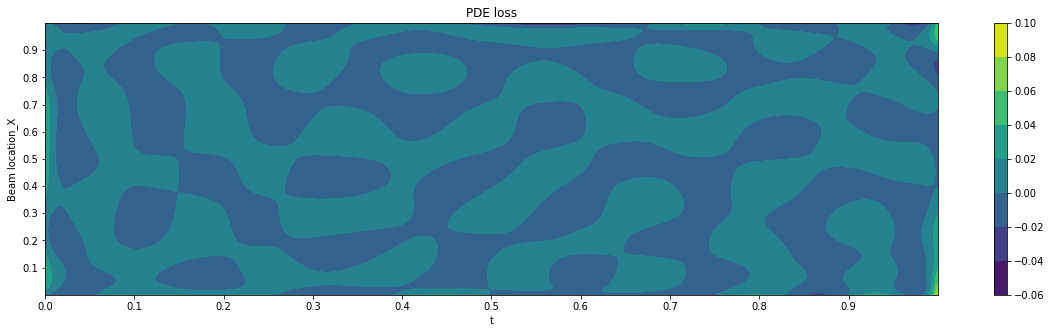

In [39]:
levels = np.linspace(-0.01,0.01,21)
fig_3 = plt.figure(1, figsize=(20, 5))
plt.plot
plt.title('PDE loss')
#plt.contourf(taxis,Xaxis,PDE_L.cpu().detach().numpy(),levels=levels)
plt.contourf(taxis,Xaxis,PDE_L.cpu().detach().numpy())
plt.xlabel('t')
plt.ylabel('Beam location_X')
plt.xticks(np.arange(0, 1, 0.1))
plt.yticks(np.arange(0.1, 1, 0.1)) 
#plt.clim(-0.3,0.3)

plt.colorbar()